In [96]:
import gzip
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow import keras
from google.colab import files
from collections import Counter
from sklearn.model_selection import train_test_split


In [3]:
uploaded=files.upload()

Saving flatland_train.data to flatland_train.data


In [4]:
def evaluate(path, model):
    X, y = pickle.load(gzip.open(path, 'rb'))
    y[y != 0] -= 2
    X = X / 255.
    acc = np.mean(model(X).numpy().argmax(axis=1) == y)
    return acc

In [5]:
path = 'flatland_train.data'
X, y = pickle.load(gzip.open(path, 'rb')) #(10000,50,50)

#data pre-proc
y[y != 0] -= 2 #jei klasė ne nulis, atimk iš jos 2, labels from (0, 4)
X = X / 255. #normalizuojam data, kad pixeliai butu rezyje (0,1)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [7]:
X_train.shape

(7000, 50, 50)

In [8]:
X_test.shape

(3000, 50, 50)

In [12]:
y_train

array([1., 0., 3., ..., 3., 1., 4.])

In [9]:
for i in range (5): #nes eilutėje turime 5 elementus, sužinome kuriuose indeksuose kiekvienos grupės elementai atsiranda
  print (np.where(y_train ==i)[0][0])

1
0
9
2
7


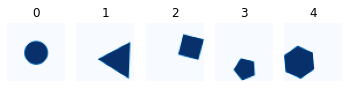

In [10]:
for i in range (5): #atspausdiname po elementą iš kiekvienos grupės
  idx=np.where(y_train==i)[0][0]
  plt.subplot(2,5,i+1)
  plt.imshow(X_train[idx], cmap='Blues')
  plt.title(i)
  plt.axis('off')

In [11]:
Counter(y) #suskaičiuojame, kiek elementų yra kiekvienoje grupėje

Counter({0.0: 1381, 1.0: 2853, 2.0: 1868, 3.0: 2137, 4.0: 1761})

In [12]:
y

array([2., 4., 3., ..., 4., 4., 3.])

In [13]:
X_train[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

# **DNN**

Pačiame pradiniame modelyje išbandžiau visokius optimizer'ius, pavyzdžiui STG, Adam (nepriskiriant learning_rate), tačiau su jais nesugebėjau parinkti tokio learning_rate, kad val_loss nešokinėtų, todėl pasirinkau dirbti su Adam optimizacija, priskiriant learning_rate 3e-4.
Taip pat šitame modelyje matome ganėtinai didelį sluoksnių skaičių, tačiau parenkant mažesnį gauname labai mažą tikslumą (bent jau kiek aš sugebėjau išbandyti).
Gautą modelį taip pat sunku pavadinti geru, kai yra toks didelis skirtumas tarp loss ir val_loss, labiau panašu į overfit'ą.

In [105]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=(50,50))) #(50,50), nes toks yra objektų dydis
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(75, activation='relu'))
model.add(keras.layers.Dense(50, activation='relu'))
model.add(keras.layers.Dense(25, activation='relu'))
model.add(keras.layers.Dense(10, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=keras.optimizers.Adam(learning_rate=3e-4), 
              metrics=['accuracy'])
model.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_26 (Flatten)        (None, 2500)              0         
                                                                 
 dense_130 (Dense)           (None, 100)               250100    
                                                                 
 dense_131 (Dense)           (None, 75)                7575      
                                                                 
 dense_132 (Dense)           (None, 50)                3800      
                                                                 
 dense_133 (Dense)           (None, 25)                1275      
                                                                 
 dense_134 (Dense)           (None, 10)                260       
                                                                 
Total params: 263,010
Trainable params: 263,010
Non-t

In [106]:
loss = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30)

Epoch 1/30
219/219 [==============================] - 3s 9ms/step - loss: 1.5690 - accuracy: 0.3826 - val_loss: 1.2421 - val_accuracy: 0.4777
Epoch 2/30
219/219 [==============================] - 2s 8ms/step - loss: 1.1784 - accuracy: 0.5107 - val_loss: 1.1512 - val_accuracy: 0.4993
Epoch 3/30
219/219 [==============================] - 2s 7ms/step - loss: 1.0422 - accuracy: 0.5693 - val_loss: 1.0549 - val_accuracy: 0.5520
Epoch 4/30
219/219 [==============================] - 2s 7ms/step - loss: 0.9094 - accuracy: 0.6284 - val_loss: 0.9090 - val_accuracy: 0.6253
Epoch 5/30
219/219 [==============================] - 2s 7ms/step - loss: 0.7978 - accuracy: 0.6791 - val_loss: 0.8337 - val_accuracy: 0.6553
Epoch 6/30
219/219 [==============================] - 2s 7ms/step - loss: 0.7135 - accuracy: 0.7076 - val_loss: 0.7837 - val_accuracy: 0.6713
Epoch 7/30
219/219 [==============================] - 2s 8ms/step - loss: 0.6427 - accuracy: 0.7487 - val_loss: 0.7334 - val_accuracy: 0.6957
Epoch 

In [107]:
pd.DataFrame(loss.history)[['loss', 'val_loss']]

,loss,val_loss
0,1.568955,1.242149
1,1.178412,1.151224
2,1.042222,1.054948
3,0.909352,0.909014
4,0.797843,0.833724
5,0.713484,0.783689
6,0.642736,0.733419
7,0.595320,0.716676
8,0.549685,0.710342
9,0.528505,0.737258


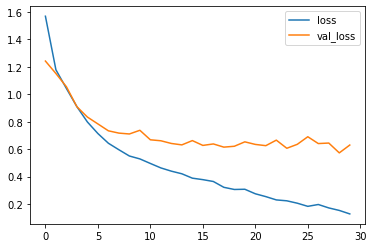

In [108]:
pd.DataFrame(loss.history)[['loss', 'val_loss']].plot()

# **Overfit**

Nors praeitas modelis ir yra panašus į overfit'ą, tačiau norėjau padaryti aiškesnį. Kaip matome, pridėjau daugiau sluoksnių ir padidinau density. Didinau sluoksnių skaičių tol, kol gavau, jog va_loss pradeda kilti (nuo apytiksliai 15 epochos)

In [109]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=(50,50)))
model.add(keras.layers.Dense(1000, activation='relu'))
model.add(keras.layers.Dense(500, activation='relu'))
model.add(keras.layers.Dense(250, activation='relu'))
model.add(keras.layers.Dense(125, activation='relu'))
model.add(keras.layers.Dense(60, activation='relu'))
model.add(keras.layers.Dense(30, activation='relu'))
model.add(keras.layers.Dense(10, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=keras.optimizers.Adam(learning_rate=3e-4), 
              metrics=['accuracy'])
model.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_27 (Flatten)        (None, 2500)              0         
                                                                 
 dense_135 (Dense)           (None, 1000)              2501000   
                                                                 
 dense_136 (Dense)           (None, 500)               500500    
                                                                 
 dense_137 (Dense)           (None, 250)               125250    
                                                                 
 dense_138 (Dense)           (None, 125)               31375     
                                                                 
 dense_139 (Dense)           (None, 60)                7560      
                                                                 
 dense_140 (Dense)           (None, 30)              

In [110]:
loss = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20)

Epoch 1/20
219/219 [==============================] - 10s 42ms/step - loss: 1.3644 - accuracy: 0.4293 - val_loss: 1.2051 - val_accuracy: 0.4857
Epoch 2/20
219/219 [==============================] - 9s 41ms/step - loss: 1.0662 - accuracy: 0.5504 - val_loss: 0.9720 - val_accuracy: 0.5863
Epoch 3/20
219/219 [==============================] - 9s 41ms/step - loss: 0.7902 - accuracy: 0.6657 - val_loss: 0.8083 - val_accuracy: 0.6547
Epoch 4/20
219/219 [==============================] - 9s 40ms/step - loss: 0.6667 - accuracy: 0.7176 - val_loss: 0.7393 - val_accuracy: 0.6883
Epoch 5/20
219/219 [==============================] - 9s 40ms/step - loss: 0.5852 - accuracy: 0.7547 - val_loss: 0.7600 - val_accuracy: 0.6817
Epoch 6/20
219/219 [==============================] - 9s 40ms/step - loss: 0.5559 - accuracy: 0.7653 - val_loss: 0.6137 - val_accuracy: 0.7417
Epoch 7/20
219/219 [==============================] - 9s 40ms/step - loss: 0.5108 - accuracy: 0.7853 - val_loss: 0.6174 - val_accuracy: 0.745

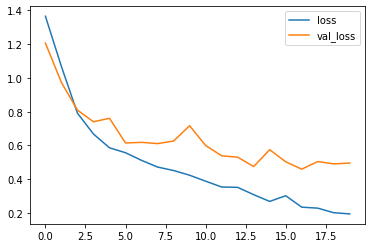

In [111]:
pd.DataFrame(loss.history)[['loss', 'val_loss']].plot()

# **Pridedam dropout**

Pridedam "dropout" komandą, kuri neleidžia modeliui overfit'int, išmetant neuronų sluoksnius. Čia vėl gi bandžiau keisti sluoksnių skaičių, density dydį, taip pat dropout dydį, nes su 0.2 gavau labai šokinėjančias loss ir val_loss kreives, jos taip pat neartėjo viena prie kitos. Vis dėlto, su šiuo modeliu nepavyko gauti labai tikslaus modelio.

In [112]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=(50,50)))
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(10, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=keras.optimizers.Adam(learning_rate=3e-4), 
              metrics=['accuracy'])
model.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_28 (Flatten)        (None, 2500)              0         
                                                                 
 dense_142 (Dense)           (None, 256)               640256    
                                                                 
 dropout_58 (Dropout)        (None, 256)               0         
                                                                 
 dense_143 (Dense)           (None, 128)               32896     
                                                                 
 dropout_59 (Dropout)        (None, 128)               0         
                                                                 
 dense_144 (Dense)           (None, 64)                8256      
                                                                 
 dropout_60 (Dropout)        (None, 64)              

Taip pat čia pridedame batch_size funkciją, kuri pagreitina skaičiavimus, nes daro didesnius žingsnius.

In [113]:
loss = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=256)

Epoch 1/50
28/28 [==============================] - 2s 42ms/step - loss: 2.0991 - accuracy: 0.1946 - val_loss: 1.8590 - val_accuracy: 0.3310
Epoch 2/50
28/28 [==============================] - 1s 34ms/step - loss: 1.9277 - accuracy: 0.2437 - val_loss: 1.7255 - val_accuracy: 0.4220
Epoch 3/50
28/28 [==============================] - 1s 34ms/step - loss: 1.8364 - accuracy: 0.2746 - val_loss: 1.6094 - val_accuracy: 0.4633
Epoch 4/50
28/28 [==============================] - 1s 33ms/step - loss: 1.7286 - accuracy: 0.3196 - val_loss: 1.5091 - val_accuracy: 0.4763
Epoch 5/50
28/28 [==============================] - 1s 33ms/step - loss: 1.6602 - accuracy: 0.3464 - val_loss: 1.4236 - val_accuracy: 0.4880
Epoch 6/50
28/28 [==============================] - 1s 34ms/step - loss: 1.5834 - accuracy: 0.3721 - val_loss: 1.3606 - val_accuracy: 0.4973
Epoch 7/50
28/28 [==============================] - 1s 33ms/step - loss: 1.5245 - accuracy: 0.4007 - val_loss: 1.3115 - val_accuracy: 0.4987
Epoch 8/50
28

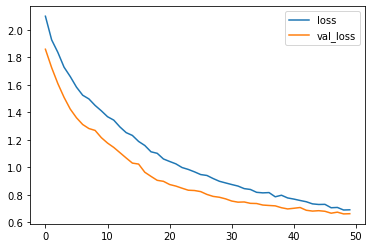

In [114]:
pd.DataFrame(loss.history)[['loss', 'val_loss']].plot()

# **CNN** (konvoliuciniai neuroniniai tinklai)



Šis modelis gaunasi pats tiksliausias, todėl jį ir naudosime.

In [115]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(32, kernel_size=(3, 3), activation = 'relu', input_shape=[50,50,1])) #conv2 naudojamas gauti aukštą tikslumą paveiksliuko atpažinime
model.add(keras.layers.BatchNormalization(axis=-1)) #leidžia kiekvienam sluoksniui mokytis nepriklausant nuo kitų sluoksnių, normalizuoja buvusių sluoksnių rezultatus
model.add(keras.layers.MaxPooling2D(pool_size=(2,2))) #sumažina input dydį
model.add(keras.layers.Conv2D(32, kernel_size=(3, 3), activation = 'relu'))
model.add(keras.layers.BatchNormalization(axis=-1))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(10, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
model.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 48, 48, 32)        320       
                                                                 
 batch_normalization_8 (Batc  (None, 48, 48, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 24, 24, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 22, 22, 32)        9248      
                                                                 
 batch_normalization_9 (Batc  (None, 22, 22, 32)       128       
 hNormalization)                                                 
                                                     

In [116]:
loss = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20)

Epoch 1/20
219/219 [==============================] - 30s 134ms/step - loss: 1.1729 - accuracy: 0.5419 - val_loss: 3.3822 - val_accuracy: 0.0973
Epoch 2/20
219/219 [==============================] - 30s 136ms/step - loss: 0.4714 - accuracy: 0.8381 - val_loss: 2.9214 - val_accuracy: 0.1477
Epoch 3/20
219/219 [==============================] - 29s 132ms/step - loss: 0.2238 - accuracy: 0.9373 - val_loss: 1.5356 - val_accuracy: 0.3810
Epoch 4/20
219/219 [==============================] - 30s 138ms/step - loss: 0.1336 - accuracy: 0.9659 - val_loss: 0.2120 - val_accuracy: 0.9520
Epoch 5/20
219/219 [==============================] - 29s 132ms/step - loss: 0.0907 - accuracy: 0.9767 - val_loss: 0.2075 - val_accuracy: 0.9570
Epoch 6/20
219/219 [==============================] - 29s 132ms/step - loss: 0.0698 - accuracy: 0.9800 - val_loss: 0.2976 - val_accuracy: 0.9250
Epoch 7/20
219/219 [==============================] - 29s 132ms/step - loss: 0.0639 - accuracy: 0.9821 - val_loss: 0.2808 - val_ac

In [117]:
pred=model.predict(X_test).argmax(axis=1)
print('Test set accuracy - {0:.02%}'.format((pred==y_test).mean()))

Test set accuracy - 97.20%


In [118]:
model.save('model.h5')

In [119]:
model = keras.models.load_model('model.h5')
evaluate('flatland_train.data', model)

0.9908

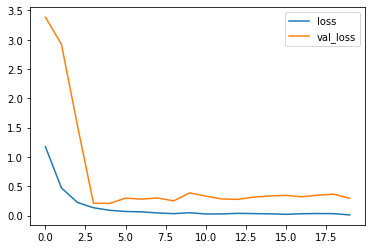

In [120]:
pd.DataFrame(loss.history)[['loss', 'val_loss']].plot()